# Author: Sebastian Apel
License: MIT


# Can an RNN learn a "trigger on/off" function?

Problem: Assume you have two input signals $X_0$ and $X_1$, and an output signal $Y_0$.  Both signals are captured over time. 
Assume that the signals $X_0$ and $X_1$ are "switching" signals for "On" and "Off", in the sense that they change the output of $Y_0$ to an "On" value or an "Off" value. Mathematically, this could be represented as: The output signal $Y_0$ is defined to be 0.8 for all timesteps after $X_0$ had the value $1$, and 0 for all time steps after $X_1$ had the value $1$. You can find a plot  below.

Question: Can a recurrent neural net successfully learn that function?

As we can see below, there are parameters for an GRU that fit the data perfectly. But: I was not able to find those parameters with rmsprop. Am I doing something wrong here or is the global optimum so hard to find that the optimizer has only a very low chance to find it?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A6AD518>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000A8808D0>], dtype=object)

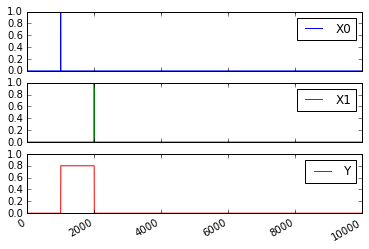

In [2]:
# build a representation of the signals
timelen = 10000

import numpy as np

# initialize the X and Y variables
Cmd = np.zeros(timelen) 
X = np.zeros((timelen, 2))
Y = np.zeros(timelen)

def switch(X,Y, time, what):

    if what == "on":
        Cmd[time] = 1
        X[time,0] = 1 # the trigger for the "on" signal
        Y[time+1:] = 0.8 # sets the level for the remaining time
        pass
    
    if what == "off":
        Cmd[time] = 2
        X[time,1] = 1 # the trigger for the "on" signal
        Y[time+1:] = 0.0 # sets the level for the remaining time
        pass
    
    
    return (X,Y)

(X,Y) = switch(X,Y, 1, "off")
(X,Y) = switch(X,Y, 1000, "on")
(X,Y) = switch(X,Y, 2000, "off")

# plot the things
import pandas as pd
df = pd.DataFrame({"X0" : X[:,0], "X1": X[:,1], "Y" : Y})
%matplotlib inline
df.plot(subplots=True, sharey=True)


# Pen and paper thoughts

A GRU should be able to model this. And it is as we will see below. Taking the GRU definition from [wildml.com](http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/), we have the following setup: 
<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/10/Screen-Shot-2015-10-23-at-10.36.51-AM.png"  width="400" height="400" />

And the following equations with $x_t$ being the input at time step $t$, and $s_t$ the output:

\begin{aligned}  
z &=\sigma(x_tU^z + s_{t-1} W^z) \\  
r &=\sigma(x_t U^r +s_{t-1} W^r) \\  
h &= tanh(x_t U^h + (s_{t-1} \circ r) W^h) \\  
s_t &= (1 - z) \circ h + z \circ s_{t-1}  
\end{aligned}  


The idea is to make sure the hidden state $s_t$ changes when $X_0$ or $X_1$ are 1 and remains unchanged otherwise.

There is a konfiguration of weights (we will see below) that can model what we want. 

PLEASE NOTE: the keras implementation slightly differs from the definition above. 

Here is the proof in keras:

Input shape: (1, 10000, 2)
Output shape: (1, 10000, 1)


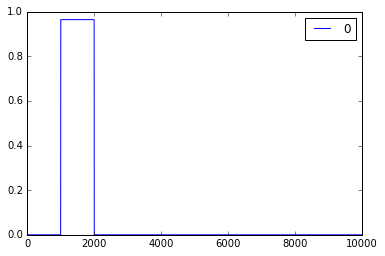

In [3]:
from keras.models import Sequential
from keras.layers import GRU


gru_size = 1   # we want a vector of dimension 1 as output
batch_size = 1 # let's use one large batch
tsteps = timelen # along our data

'''
# GRU implementation in Keras https://github.com/fchollet/keras/blob/master/keras/layers/recurrent.py#L816

x_z = K.dot(x * B_W[0], self.W_z) + self.b_z
x_r = K.dot(x * B_W[1], self.W_r) + self.b_r
x_h = K.dot(x * B_W[2], self.W_h) + self.b_h

z = self.inner_activation(x_z + K.dot(h_tm1 * B_U[0], self.U_z))
r = self.inner_activation(x_r + K.dot(h_tm1 * B_U[1], self.U_r))

hh = self.activation(x_h + K.dot(r * h_tm1 * B_U[2], self.U_h))
h = z * h_tm1 + (1 - z) * hh

# X = (0,0)
# X_z = (0,0) * W_z + b_z = (1)
'''


model = Sequential()
model.add(GRU(gru_size, batch_input_shape=(batch_size, tsteps, 2), return_sequences=True, stateful=False,
              weights = [
                    # Let's set the weights to our pen and paper thoughts
                    -10 * np.ones((2,1)), # W_z
                    np.zeros((1,1)), # U_z
                    5 * np.ones((1)), # b_z  
            
                    np.zeros((2,1)), # W_r
                    np.zeros((1,1)), # U_r
                    np.zeros((1)), # b_r
                    
                    1 * np.array([[1,-1]]).transpose(), # W_h
                    np.zeros((1,1)), # U_h
                    1*np.ones((1)), # b_h                    
                ]             
             ))

# conert our data into somthing Keras expects
X_in = np.zeros((1, timelen, 2))
X_in[0,:,0] = X[:,0]
X_in[0,:,1] = X[:,1]
print('Input shape:', X_in.shape)

expected_output = np.zeros((1, timelen,1))
expected_output[0,:,0] = Y

print('Output shape:', expected_output.shape)

# print some info on our layers to check if weights are set
if False: # uncomment if you want info on your layer
    for layer in model.layers:
        g=layer.get_config()
        h=layer.get_weights()
        print (g)
        print (h)


Y_predicted = model.predict(X_in)

pd.DataFrame(Y_predicted[0,:]).plot()


For our purposes, this is close enough for now: the exact level of the output could be calibrated with an additional dense linear layer.

# Now, can we also learn this from the data?

Now that we know a perfect solution exists - can we make our model learn it from the data?

In [110]:
# initialize the same model
model = Sequential()
model.add(GRU(gru_size, batch_input_shape=(batch_size, tsteps, 2), return_sequences=True, stateful=False))

# but now, fit it from the data
model.compile(loss='mse', optimizer='rmsprop')
model.fit(X_in, expected_output, shuffle=False)

Epoch 1/10
1/1 [==============================] - 1s - loss: 0.0640
Epoch 2/10
1/1 [==============================] - 1s - loss: 0.0629
Epoch 3/10
1/1 [==============================] - 1s - loss: 0.0622
Epoch 4/10
1/1 [==============================] - 1s - loss: 0.0616
Epoch 5/10
1/1 [==============================] - 1s - loss: 0.0612
Epoch 6/10
1/1 [==============================] - 1s - loss: 0.0608
Epoch 7/10
1/1 [==============================] - 1s - loss: 0.0604
Epoch 8/10
1/1 [==============================] - 1s - loss: 0.0601
Epoch 9/10
1/1 [==============================] - 1s - loss: 0.0599
Epoch 10/10
1/1 [==============================] - 1s - loss: 0.0596


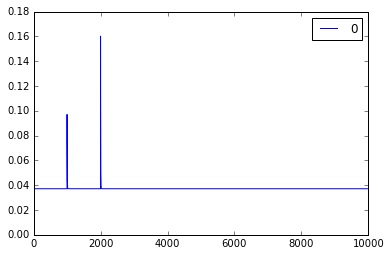

In [111]:
# let's see what the model has learned
Y_predicted = model.predict(X_in)
pd.DataFrame(Y_predicted[0,:]).plot()

In [115]:
# maybe we need more training time
model.fit(X_in, expected_output, nb_epoch=100, verbose=2, batch_size=timelen)


Epoch 1/100
1s - loss: 0.0575
Epoch 2/100
1s - loss: 0.0575
Epoch 3/100
1s - loss: 0.0575
Epoch 4/100
1s - loss: 0.0575
Epoch 5/100
1s - loss: 0.0575
Epoch 6/100
1s - loss: 0.0575
Epoch 7/100
1s - loss: 0.0575
Epoch 8/100
1s - loss: 0.0575
Epoch 9/100
1s - loss: 0.0575
Epoch 10/100
1s - loss: 0.0575
Epoch 11/100
1s - loss: 0.0575
Epoch 12/100
1s - loss: 0.0575
Epoch 13/100
1s - loss: 0.0575
Epoch 14/100
1s - loss: 0.0575
Epoch 15/100
1s - loss: 0.0575
Epoch 16/100
1s - loss: 0.0575
Epoch 17/100
1s - loss: 0.0575
Epoch 18/100
1s - loss: 0.0575
Epoch 19/100
1s - loss: 0.0575
Epoch 20/100
1s - loss: 0.0575
Epoch 21/100
1s - loss: 0.0575
Epoch 22/100
1s - loss: 0.0575
Epoch 23/100
1s - loss: 0.0575
Epoch 24/100
1s - loss: 0.0575
Epoch 25/100
1s - loss: 0.0575
Epoch 26/100
1s - loss: 0.0575
Epoch 27/100
1s - loss: 0.0575
Epoch 28/100
1s - loss: 0.0575
Epoch 29/100
1s - loss: 0.0575
Epoch 30/100
1s - loss: 0.0575
Epoch 31/100


KeyboardInterrupt: 

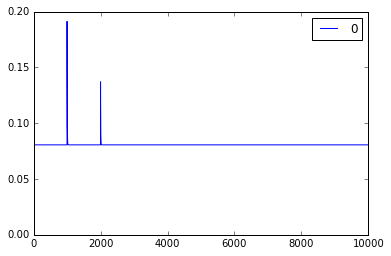

In [113]:
# let's plot our fitted solution
Y_predicted = model.predict(X_in)
pd.DataFrame(Y_predicted[0,:]).plot()

More training time is not makeing a difference. It seems we are stuck in this local optimum.

So the question is: What needs to be done differently to learn this? Is this a vanishing / exploding gradient problem?
Or is it very hard to learn? Suggestions are highly welcome...

In [106]:
# what happens if we build the model again (and therefore get differently initialized weights?)

tsteps=10
X_in = np.zeros((timelen/10,tsteps, 2))
X_in[:,:,0] = X[:,0].reshape((1000,tsteps))
X_in[:,:,1] = X[:,1].reshape((1000,tsteps))

expected_output = np.zeros((timelen/10,tsteps,1))
expected_output[:,:,0] = Y.reshape((1000,tsteps))

model = Sequential()
model.add(GRU(gru_size, batch_input_shape=(batch_size, tsteps, 2), return_sequences=True, stateful=True, shuffle=False, unroll=True))
model.compile(loss='mse', optimizer='rmsprop')
model.fit(X_in, expected_output, nb_epoch=10, verbose=2)


D:\PortableApps\WinPython-64bit-3.4.4.2\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
D:\PortableApps\WinPython-64bit-3.4.4.2\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


AssertionError: Keyword argument not understood: shuffle

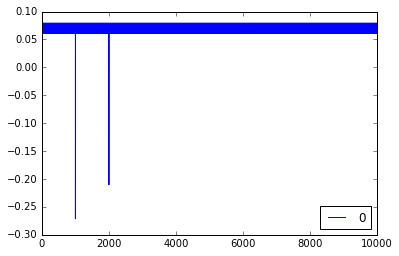

In [101]:
Y_predicted = model.predict(X_in)
pd.DataFrame(Y_predicted[:,:,0].reshape((10000,1))).plot()

Epoch 1/200
0s - loss: 0.0577
Epoch 2/200
0s - loss: 0.0577
Epoch 3/200
0s - loss: 0.0577
Epoch 4/200
0s - loss: 0.0577
Epoch 5/200
0s - loss: 0.0577
Epoch 6/200
0s - loss: 0.0577
Epoch 7/200
0s - loss: 0.0577
Epoch 8/200
0s - loss: 0.0577
Epoch 9/200
0s - loss: 0.0577
Epoch 10/200
0s - loss: 0.0577
Epoch 11/200
0s - loss: 0.0577
Epoch 12/200
0s - loss: 0.0577
Epoch 13/200
0s - loss: 0.0577
Epoch 14/200
0s - loss: 0.0577
Epoch 15/200
0s - loss: 0.0577
Epoch 16/200
0s - loss: 0.0577
Epoch 17/200
0s - loss: 0.0577
Epoch 18/200
0s - loss: 0.0577
Epoch 19/200
0s - loss: 0.0577
Epoch 20/200
0s - loss: 0.0577
Epoch 21/200
0s - loss: 0.0577
Epoch 22/200
0s - loss: 0.0577
Epoch 23/200
0s - loss: 0.0577
Epoch 24/200
0s - loss: 0.0577
Epoch 25/200
0s - loss: 0.0577
Epoch 26/200
0s - loss: 0.0577
Epoch 27/200
0s - loss: 0.0577
Epoch 28/200
0s - loss: 0.0577
Epoch 29/200
0s - loss: 0.0577
Epoch 30/200
0s - loss: 0.0577
Epoch 31/200
0s - loss: 0.0577
Epoch 32/200
0s - loss: 0.0577
Epoch 33/200
0s -

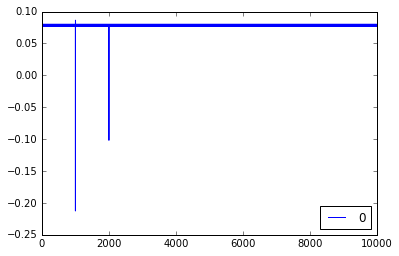

In [105]:
model.fit(X_in, expected_output, nb_epoch=200, verbose=2, batch_size=1000)
Y_predicted = model.predict(X_in)
pd.DataFrame(Y_predicted[:,:,0].reshape((10000,1))).plot()

In [50]:
# what happens if we build the model again (and therefore get differently initialized weights?)
from keras.layers import TimeDistributed, Dense
tsteps=1
batch_size = 25

X_in = np.zeros((timelen,tsteps, 2))
X_in[:,0,0] = X[:,0]
X_in[:,0,1] = X[:,1]

expected_output = np.zeros((timelen,1,1))
expected_output[:,0,0] = np.append(Y[1:],Y[0])

if True:
    model = Sequential()
    model.add(GRU(gru_size, batch_input_shape=(batch_size, tsteps, 2), return_sequences=True, stateful=True))
    model.add(GRU(gru_size, batch_input_shape=(batch_size, tsteps, 2), return_sequences=True, stateful=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='rmsprop')

epochs = 500

for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(X_in,
              expected_output,
              batch_size=batch_size,
              verbose=2,
              nb_epoch=1,
              shuffle=False)
    model.reset_states()


Epoch 0 / 500
Epoch 1/1
0s - loss: 0.1104
Epoch 1 / 500
Epoch 1/1
0s - loss: 0.1095
Epoch 2 / 500
Epoch 1/1
0s - loss: 0.1085
Epoch 3 / 500
Epoch 1/1
0s - loss: 0.1075
Epoch 4 / 500
Epoch 1/1
0s - loss: 0.1064
Epoch 5 / 500
Epoch 1/1
0s - loss: 0.1052
Epoch 6 / 500
Epoch 1/1
0s - loss: 0.1040
Epoch 7 / 500
Epoch 1/1
0s - loss: 0.1037
Epoch 8 / 500
Epoch 1/1
0s - loss: 0.1040
Epoch 9 / 500
Epoch 1/1
0s - loss: 0.1060
Epoch 10 / 500
Epoch 1/1
0s - loss: 0.1115
Epoch 11 / 500
Epoch 1/1
0s - loss: 0.1159
Epoch 12 / 500
Epoch 1/1
0s - loss: 0.1175
Epoch 13 / 500
Epoch 1/1
0s - loss: 0.1177
Epoch 14 / 500
Epoch 1/1
0s - loss: 0.1163
Epoch 15 / 500
Epoch 1/1
0s - loss: 0.1140
Epoch 16 / 500
Epoch 1/1
0s - loss: 0.1114
Epoch 17 / 500
Epoch 1/1
0s - loss: 0.1083
Epoch 18 / 500
Epoch 1/1
0s - loss: 0.1052
Epoch 19 / 500
Epoch 1/1
0s - loss: 0.1025
Epoch 20 / 500
Epoch 1/1
0s - loss: 0.1004
Epoch 21 / 500
Epoch 1/1
0s - loss: 0.0987
Epoch 22 / 500
Epoch 1/1
0s - loss: 0.0973
Epoch 23 / 500
Epoch 

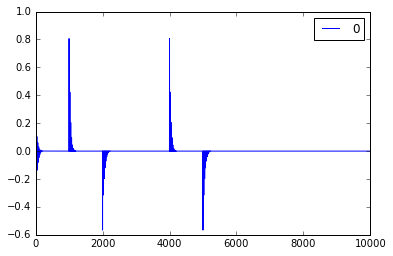

In [51]:
Y_predicted = model.predict(X_in, batch_size=batch_size)
pd.DataFrame(Y_predicted[:,0,0]).plot()

In [44]:
(X,Y) = switch(X,Y, 4000, "on")
(X,Y) = switch(X,Y, 5000, "off")